# ASSIGNMENT 5 XRAYS SYED MUHAMMAD ZAIN

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
directory = Path('/content/drive/MyDrive/Colab Notebooks/Assignment 5/Xraydataset_DL_Assignment/TRAIN_DATA')
FileP = list(directory.glob(r'**/*.jpg'))

In [4]:
def proc_img(FP):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(FP[i]).split("/")[-2] \
              for i in range(len(FP))]

    fileP = pd.Series(FP, name='Filepath').astype(str)
    LBLS = pd.Series(labels, name='Label')

    
    df1 = pd.concat([fileP, LBLS], axis=1)

   
    df1= df1.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df1

df1 = proc_img(FileP)

print(f'No of pics in data: {df1.shape[0]}\n')
print(f'No of labels: {len(df1.Label.unique())}\n')
print(f'the labels: {df1.Label.unique()}')



No of pics in data: 3216

No of labels: 3

the labels: ['CLASS 1' 'CLASS 0' 'CLASS 2']


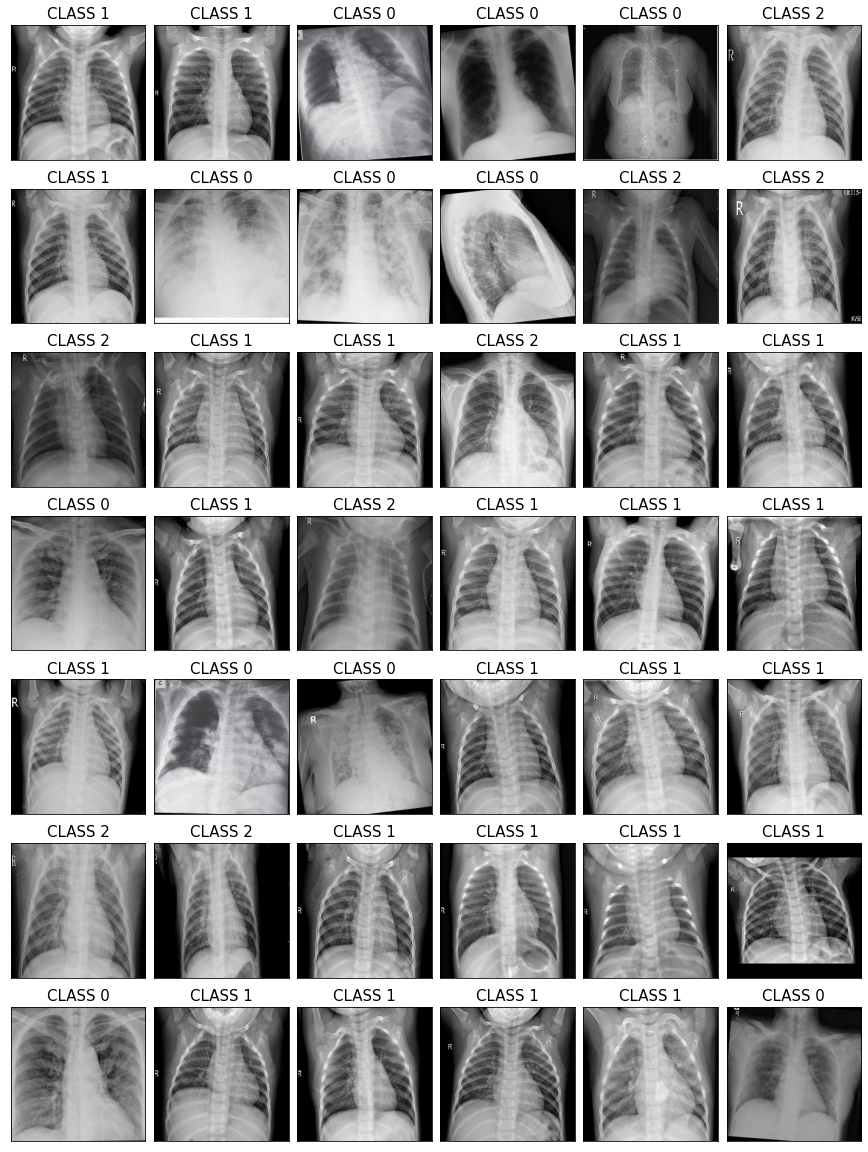

In [5]:
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(12, 16),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df1.Filepath[i]))
    ax.set_title(df1.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [6]:
directory1 = Path('/content/drive/MyDrive/Colab Notebooks/Assignment 5/Xraydataset_DL_Assignment/TEST_DATA')
FileP1 = list(directory1.glob(r'**/*.jpg'))
df2 = proc_img(FileP1)

print(f'No of pics in data: {df2.shape[0]}\n')
print(f'No of labels: {len(df2.Label.unique())}\n')
print(f'the labels: {df2.Label.unique()}')

No of pics in data: 805

No of labels: 3

the labels: ['CLASS 1' 'CLASS 2' 'CLASS 0']


In [7]:
df2.shape

(805, 2)

In [8]:
df1=df1.sample(frac=0.5)
df2=df2.sample(frac=0.5)


In [9]:
print(df1.shape)
print(df2.shape)

(1608, 2)
(402, 2)


In [10]:
def create_gen():
    
    traingen = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.2
    )

    testgen= tf.keras.preprocessing.image.ImageDataGenerator()
    

    trainingimages = traingen.flow_from_dataframe(
        dataframe=df1,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
         rotation_range=30, 
         zoom_range=0.15,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.15,
         horizontal_flip=True,
         fill_mode="nearest"
    )

    validationimages = traingen.flow_from_dataframe(
        dataframe=df1,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, 
         zoom_range=0.15,
         width_shift_range=0.2,
         height_shift_range=0.2,
         shear_range=0.15,
         horizontal_flip=True,
         fill_mode="nearest"
    )

    testingimages = testgen.flow_from_dataframe(
        dataframe=df2,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return traingen,testgen,trainingimages,validationimages,testingimages

In [11]:
#diving into training and validation testing is same
traingen,testgen,trainingimages,validationimages,testingimages=create_gen()

Found 1287 validated image filenames belonging to 3 classes.
Found 321 validated image filenames belonging to 3 classes.
Found 402 validated image filenames belonging to 3 classes.


In [12]:
def get_model(model):

    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    preTM = model(**kwargs)
    preTM.trainable = False
    
    inputs = preTM.input

   

    outputs = tf.keras.layers.Dense(3, activation='softmax')(preTM.output)

    Fmodel = tf.keras.Model(inputs=inputs, outputs=outputs)

    Fmodel.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return Fmodel

In [13]:
traingen,testgen,trainingimages,validationimages,testingimages=create_gen()


model = get_model( eval("tf.keras.applications."+ "DenseNet169") )

hist= model.fit(trainingimages,
                    validation_data=validationimages,
                    epochs=10,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )

Found 1287 validated image filenames belonging to 3 classes.
Found 321 validated image filenames belonging to 3 classes.
Found 402 validated image filenames belonging to 3 classes.
Epoch 1/10
41/41 [==============================] - 284s 7s/step - loss: 0.7926 - accuracy: 0.6671 - val_loss: 0.3826 - val_accuracy: 0.8754
Epoch 2/10
41/41 [==============================] - 266s 7s/step - loss: 0.3308 - accuracy: 0.8838 - val_loss: 0.2790 - val_accuracy: 0.9097
Epoch 3/10
41/41 [==============================] - 271s 7s/step - loss: 0.2050 - accuracy: 0.9403 - val_loss: 0.2342 - val_accuracy: 0.9221
Epoch 4/10
41/41 [==============================] - 270s 7s/step - loss: 0.2029 - accuracy: 0.9441 - val_loss: 0.2178 - val_accuracy: 0.9283
Epoch 5/10
41/41 [==============================] - 277s 7s/step - loss: 0.1641 - accuracy: 0.9465 - val_loss: 0.1915 - val_accuracy: 0.9221
Epoch 6/10
41/41 [==============================] - 275s 7s/step - loss: 0.1396 - accuracy: 0.9657 - val_loss: 0.1

In [14]:
predictions = model.predict(testingimages)
predictions = np.argmax(predictions,axis=1)

# Map the label
labels = (trainingimages.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predictions]

# Get the accuracy on the test set
YTEST = list(df2.Label)
accuracy = accuracy_score(YTEST,predictions)


In [15]:
print("testing accuracy is ")
accuracy

testing accuracy is 


0.9228855721393034

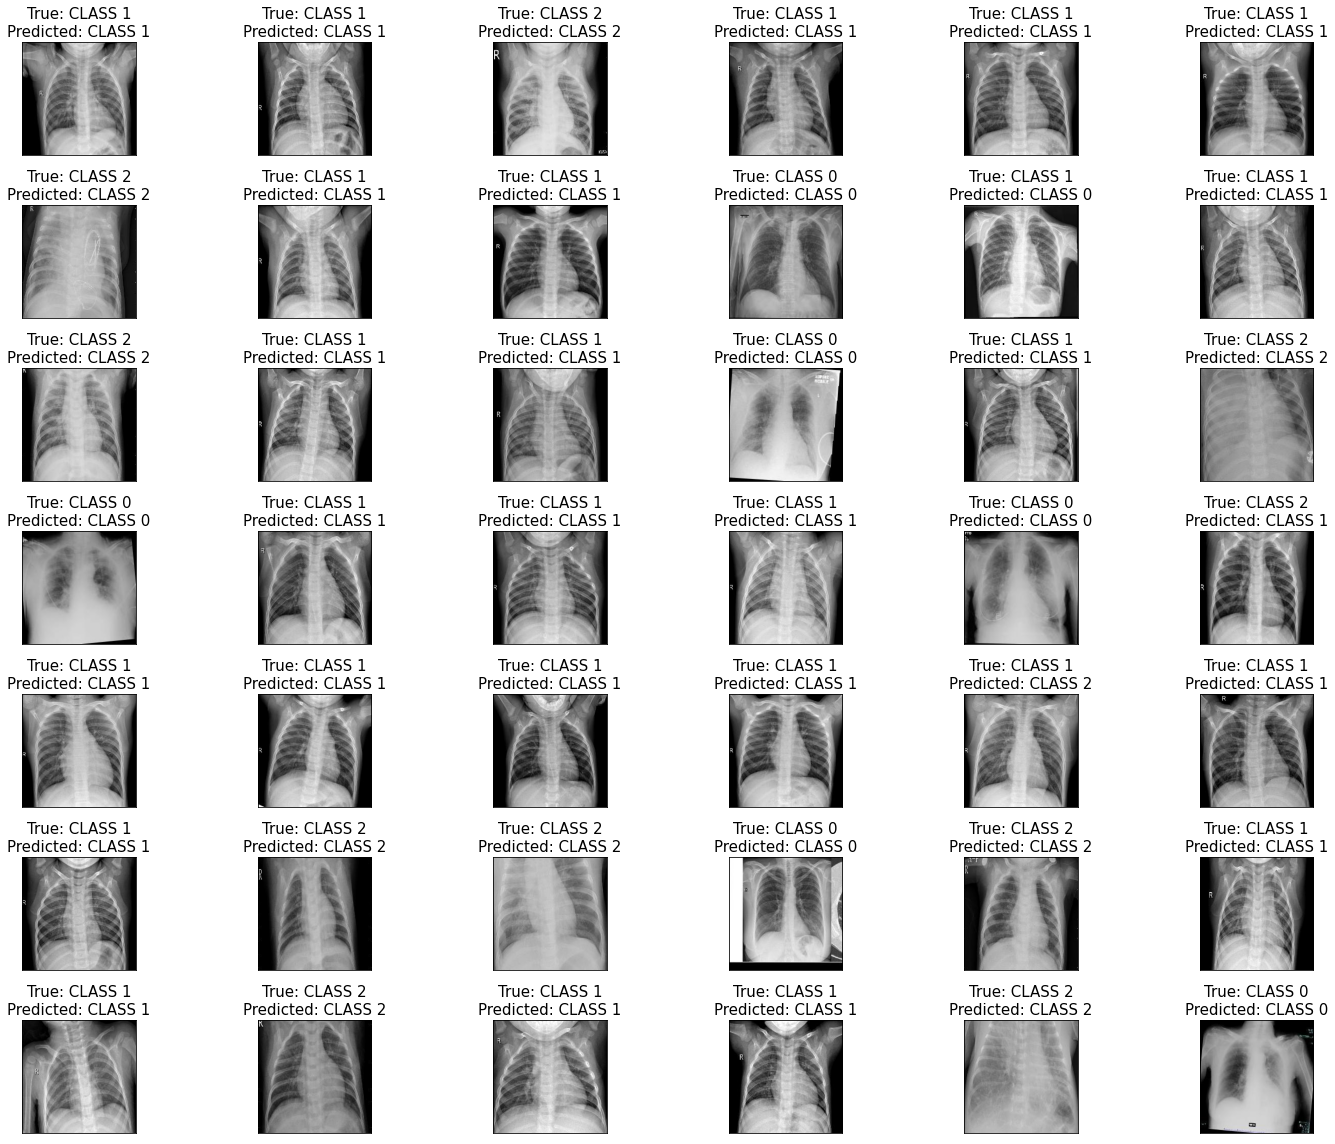

In [16]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(20, 16),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df2.Filepath.iloc[i]))
    ax.set_title(f"True: {df2.Label.iloc[i].split('_')[0]}\nPredicted: {predictions[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()